# Import des outils / jeu de données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTENC
from keras import layers
from lightgbm import LGBMClassifier
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras

2023-04-13 16:55:15.897775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 16:55:15.941900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 16:55:15.942708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 16:55:16.647944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 0

In [3]:
np.random.seed(SEED)
sns.set_theme()

In [4]:
df = pd.read_csv(
    "data/data-cleaned-feature-engineering.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

## Variables globales

In [5]:
var_numeriques = [
    "Year_Birth",
    "Income",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

In [6]:
var_categoriques = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
]

In [7]:
LABELS = (0, 1)

## Fonctions et variables utiles

In [8]:
score_modeles = []

**Tableau.** Informations sur notre classification

|:---------------------------|:----------------------------------|
| **Objectif métier**        | Prédire l'acceptation à une campagne marketing |
| **Problème technique**     | Classification binaire supervisée |
| **Métrique**               | Score F1 sur la classe 1 (clients qui acceptent)<br>À score F1 égal, on choisit la meilleure précision sur la classe 1 |
| **Méthode d'entraînement** | Validation croisée en 5 blocs     |
| **Pré-traitement**         | Variables quantitatives : centrer/réduire<br>Variables qualitatives : OneHot Encoding (Tableau Disjonctif Complet) |
| **Équilibrage des classes**| 1) Aucun<br>2) Sous-échantillonnage aléatoire manuel<br>3) Sur-échantillonnage avec SMOTE |


In [9]:
def evaluate_models(models, prefix, X_train, X_test, y_train, y_test):
    """Evalue tous les modèles dans `models` et sauvegarde les résultats avec un préfixe `prefix`
    (utile pour distinguer les différentes stratégies de pré-traitement des données)."""
    results = []

    for model, model_name in models:
        name = f"{prefix}/{model_name}"

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        precision = accuracy_score(y_test, y_pred)
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=make_scorer(f1_score, labels=[LABELS[1]]),
        )
        scores_mean = scores.mean()
        scores_std = scores.std()

        # clf_report = pd.DataFrame(
        #     classification_report(y_test, y_pred, output_dict=True)
        # ).T
        # cm = confusion_matrix(y_test, y_pred, labels=LABELS, normalize="true")
        # # sns.heatmap(cm, annot=True, cmap="Purples", vmin=0, vmax=1)
        #
        # score_f1_classe1 = clf_report.iloc[1, 2]

        results.append(
            [
                name,
                scores_mean,
                #             scores_std,
            ]
        )
        score_modeles.extend(
            (
                [
                    name,
                    "score_f1_classe1",
                    scores_mean,
                    #               scores_std,
                    precision,
                ],
            )
        )

    return results

# Liste des modèles

**Tableau.** Liste des modèles de notre étude

|:---------------------------|:----------------------------------|
| **Modèles de référence**   | Classificateur Idiot Uniforme (50% de oui et 50% de non)<br>Classificateur Idiot Constant 1 (100% de oui) |
| **Modèles linéaires**  | Régression logistique<br>Analyse Discriminante Linéaire |
| **Arbres de décision**               | Arbre de décision<br>Forêt d'arbres de décision (Random Forest) |
| **Gradient Boosting** | XGBoost<br>LightGBM<br>CatBoost |
| **Machine à vecteurs de support (SVM)** | Classificateur SVM linéaire |
| **k plus proches voisins (k-NN)** | Classificateur k-nn (5 voisins)<br>Classificateur k-nn (15 voisins) |
| **Modèle de vote**| Modèle de "Vote à la majorité" sur 5 modèles :<br>- Régression logistique<br>- Analyse discriminante linéaire<br>- Random Forest<br>- XGBoost<br>- CatBoost |
| **Réseau de neurones**| Réseau de neurones à 5 couches et 1 600 neurones |


In [10]:
models = [
    [DummyClassifier(strategy="uniform", random_state=SEED), "DummyClassifier_Uniform"],
    [
        DummyClassifier(strategy="constant", constant=1, random_state=SEED),
        "DummyClassifier_Constant1",
    ],
    [LogisticRegression(random_state=SEED), "LogisticRegression"],
    [LinearDiscriminantAnalysis(), "LinearDiscriminantAnalysis"],
    [DecisionTreeClassifier(random_state=SEED), "DecisionTreeClassifier"],
    [RandomForestClassifier(random_state=SEED), "RandomForestClassifier"],
    [xgboost.XGBClassifier(random_state=SEED), "XGBClassifier"],
    [CatBoostClassifier(random_state=SEED, verbose=False), "CatBoostClassifier"],
    [LGBMClassifier(random_state=SEED), "LGBMClassifier"],
    [LinearSVC(random_state=SEED), "LinearSVC"],
    # [BernoulliNB(), "BernoulliNB"],
    # [ComplementNB(), "ComplementNB"],
    [KNeighborsClassifier(), "KNeighborsClassifier5"],
    [KNeighborsClassifier(n_neighbors=15), "KNeighborsClassifier15"],
    [
        VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(random_state=SEED)),
                ("lda", LinearDiscriminantAnalysis()),
                ("dt", RandomForestClassifier(random_state=SEED)),
                ("xgb", xgboost.XGBClassifier(random_state=SEED)),
                ("catboost", CatBoostClassifier(random_state=SEED, verbose=False)),
            ],
            voting="soft",
        ),
        "VotingClassifier",
    ],
]

# Traitement des données

## Pipeline Scaler & OneHotEncoding

In [11]:
var_cat_non_ohe = [
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
    "HasAcceptedCampaigns",
]

In [12]:
df["HasAcceptedCampaigns"] = df["HasAcceptedCampaigns"].astype(int)

In [13]:
var_cat_ohe = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "NbAcceptedCampaigns",
    "NbChildren",
]

In [14]:
# ohe = OneHotEncoder()

In [15]:
# ohe.fit_transform(df[var_cat_ohe])

In [16]:
df[var_categoriques].head()

,Education,Marital_Status,Kidhome,Teenhome,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
ID,,,,,,,,,,
5524,Graduation,Single,0,0,0,0,0,0,0,1
2174,Graduation,Single,1,1,0,0,0,0,0,0
4141,Graduation,Together,0,0,0,0,0,0,0,0
6182,Graduation,Together,1,0,0,0,0,0,0,0
5324,PhD,Married,1,0,0,0,0,0,0,0


In [17]:
preprocessor = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        ("ohe", OneHotEncoder(), var_cat_ohe),
        ("scaler", RobustScaler(), var_numeriques),
    ],
)

In [18]:
X = df.drop(columns=["Response", "Dt_Customer"])

In [19]:
preprocessor.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(),
                                 ['Education', 'Marital_Status', 'Kidhome',
                                  'Teenhome', 'NbAcceptedCampaigns',
                                  'NbChildren']),
                                ('scaler', RobustScaler(),
                                 ['Year_Birth', 'Income', 'Recency', 'MntWines',
                                  'MntFruits', 'MntMeatProducts',
                                  'MntFishProducts', 'MntSweetProducts',
                                  'MntGoldProds', 'NumDealsPurchases',
                                  'NumWebPurchases', 'NumCatalogPurchases',
                                  'NumStorePurchases', 'NumWebVisitsMonth'])])

In [20]:
preprocessor.transform(X)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
nouveau_df = pd.DataFrame(preprocessor.transform(X), index=df.index)

In [22]:
nouveau_df.shape

(2045, 45)

In [23]:
# pipeline = Pipeline(steps=[("scaler", RobustScaler())])

# preprocessor = ColumnTransformer(
#     remainder="passthrough",
#     transformers=[
#         ("std", standard_transformer, [3]),
#     ],
# )

In [24]:
# under_sampling_manuel = Pipeline(steps=[()])

## Par défaut

In [25]:
y = df[["Response"]].astype(int)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [27]:
nouveau_df.shape

(2045, 45)

In [28]:
prefix = "défaut"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/vi

In [29]:
sorted(results, key=lambda x: x[1], reverse=True)

[['défaut/LogisticRegression', 0.5661102610469699],
 ['défaut/LinearDiscriminantAnalysis', 0.545850812857146],
 ['défaut/LinearSVC', 0.5364438866364412],
 ['défaut/XGBClassifier', 0.532459629438341],
 ['défaut/VotingClassifier', 0.5323949617633829],
 ['défaut/LGBMClassifier', 0.5062491064786723],
 ['défaut/CatBoostClassifier', 0.46650293920385055],
 ['défaut/RandomForestClassifier', 0.4129770928134099],
 ['défaut/DecisionTreeClassifier', 0.4031512852882514],
 ['défaut/KNeighborsClassifier5', 0.29592120967280766],
 ['défaut/DummyClassifier_Constant1', 0.2577170494948925],
 ['défaut/DummyClassifier_Uniform', 0.23240950411492073],
 ['défaut/KNeighborsClassifier15', 0.1512101311060322]]

## Équilibrage des classes

### Under-sampling (manuel)

In [30]:
# samples0 = df[df["Response"] == 0].sample(350, random_state=SEED)

In [31]:
# X_eq = pd.concat((samples0, df[df["Response"] == 1]))

In [32]:
# X_eq["Response"].hist()

In [33]:
# y_eq = X_eq.pop("Response").astype(int)

In [34]:
# X_eq = pd.get_dummies(X_eq.drop(columns=["Dt_Customer"]))

In [35]:
# df["Response"].value_counts()

In [36]:
NB_A_SUPPRIMER = 1400
drop_indices = np.random.choice(
    nouveau_df[y["Response"] == 0].index, NB_A_SUPPRIMER, replace=False
)
df_subset = nouveau_df.drop(drop_indices)

In [37]:
y_eq = y.drop(index=drop_indices)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df_subset, y_eq, test_size=0.2, random_state=SEED
)

In [39]:
prefix = "éq_classes"
results = evaluate_models(models, prefix, X_train, X_test, y_train, y_test)

/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/vi

In [40]:
sorted(results, key=lambda x: x[1], reverse=True)

[['éq_classes/VotingClassifier', 0.7920376025815108],
 ['éq_classes/LogisticRegression', 0.7907612086833206],
 ['éq_classes/LinearSVC', 0.7869783673914641],
 ['éq_classes/LinearDiscriminantAnalysis', 0.785353929075898],
 ['éq_classes/CatBoostClassifier', 0.7747090301003345],
 ['éq_classes/RandomForestClassifier', 0.7713864171114406],
 ['éq_classes/LGBMClassifier', 0.7583612709312677],
 ['éq_classes/XGBClassifier', 0.7532764730395318],
 ['éq_classes/KNeighborsClassifier15', 0.6929860582879729],
 ['éq_classes/KNeighborsClassifier5', 0.6789877486793301],
 ['éq_classes/DecisionTreeClassifier', 0.652775949396412],
 ['éq_classes/DummyClassifier_Constant1', 0.6527459468635939],
 ['éq_classes/DummyClassifier_Uniform', 0.5037383177570093]]

### Over-sampling (SMOTE)

In [41]:
cat_cols = list(X.select_dtypes(include=["category", "int", "bool"]).columns)

In [42]:
cat_cols_index = list(map(lambda c: list(X.columns).index(c), cat_cols))

In [43]:
list(X.iloc[:, cat_cols_index].columns)

['Year_Birth',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'NbAcceptedCampaigns',
 'HasAcceptedCampaigns',
 'NbChildren']

In [44]:
sm = SMOTENC(
    categorical_features=cat_cols_index,
    random_state=SEED,
)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    nouveau_df, y, test_size=0.2, random_state=SEED
)

In [46]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [47]:
y_train_sm.value_counts(normalize=True)

Response
0           0.5
1           0.5
dtype: float64

In [48]:
prefix = "SMOTE"
results = evaluate_models(models, prefix, X_train_sm, X_test, y_train_sm, y_test)

/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/skl

In [49]:
sorted(results, key=lambda x: x[1], reverse=True)

[['SMOTE/RandomForestClassifier', 0.9234477974804912],
 ['SMOTE/VotingClassifier', 0.9013843359078016],
 ['SMOTE/CatBoostClassifier', 0.9004915087693026],
 ['SMOTE/XGBClassifier', 0.8978744894662836],
 ['SMOTE/LGBMClassifier', 0.8934388194265583],
 ['SMOTE/KNeighborsClassifier5', 0.8788903877117182],
 ['SMOTE/LogisticRegression', 0.860745532737884],
 ['SMOTE/KNeighborsClassifier15', 0.8560527601702571],
 ['SMOTE/DecisionTreeClassifier', 0.8559027958304819],
 ['SMOTE/LinearSVC', 0.8556418039866704],
 ['SMOTE/LinearDiscriminantAnalysis', 0.8493396594425949],
 ['SMOTE/DummyClassifier_Constant1', 0.666666475661118],
 ['SMOTE/DummyClassifier_Uniform', 0.5100828801879957]]

# Réseau de neurones

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df_subset, y_eq, test_size=0.2, random_state=SEED
)

In [51]:
X_train = np.asarray(X_train).astype("float32")
y_train = np.asarray(y_train).astype("float32")
X_test = np.asarray(X_test).astype("float32")
y_test = np.asarray(y_test).astype("float32")

In [52]:
X_train.shape

(516, 45)

In [53]:
np.random.seed(0)
model = keras.Sequential(
    [
        layers.Dense(400, activation="relu", input_shape=[X_train.shape[1]]),
        layers.Dense(400, activation="relu"),
        layers.Dense(400, activation="sigmoid"),
        layers.Dense(400, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

2023-04-13 17:01:16.982046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [54]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],  # "binary_accuracy"
)

In [55]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [56]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    # validation_split=0.2,
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  # hide the output because we have so many epochs
)

Best Validation Loss: 0.4999
Best Validation Accuracy: 0.7752


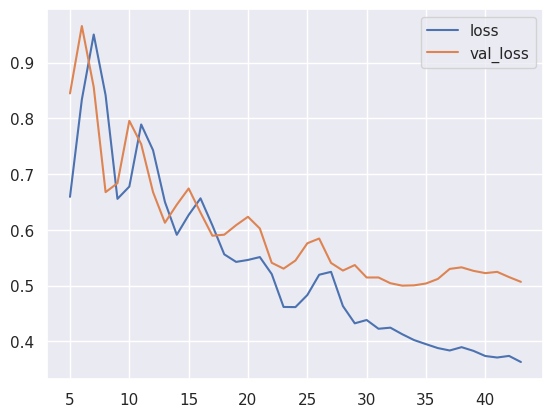

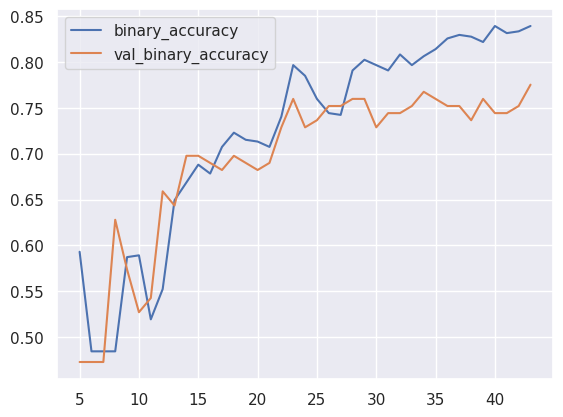

In [57]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["binary_accuracy", "val_binary_accuracy"]].plot()

print(
    ("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(
        history_df["val_loss"].min(), history_df["val_binary_accuracy"].max()
    )
)

In [58]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 1ms/step


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: ylabel='Count'>

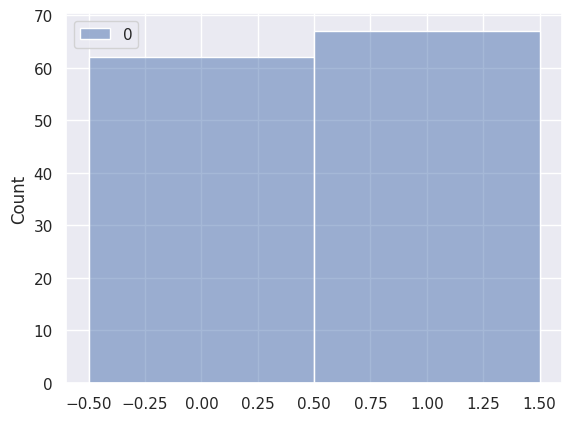

In [59]:
sns.histplot(y_pred > 0.5, discrete=True)

In [60]:
y_pred_old = y_pred

In [61]:
y_pred = y_pred > 0.5

In [62]:
print(classification_report(y_test, y_pred, labels=LABELS))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        68
           1       0.72      0.79      0.75        61

    accuracy                           0.75       129
   macro avg       0.75      0.75      0.75       129
weighted avg       0.76      0.75      0.75       129



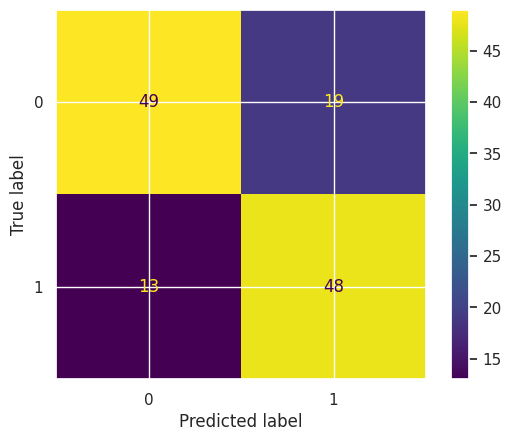

In [63]:
cm = confusion_matrix(y_test, y_pred, labels=LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot()

In [64]:
nom_modele = "Réseau de Neurones"
# ajout_score(model, nom_modele, y_test, y_pred)

# Diagnostic du modèle

## RandomForest feature importance

In [65]:
nom_colonnes = preprocessor.get_feature_names_out(X.columns)

In [66]:
nom_colonnes = list(map(lambda x: x.split("__")[1], nom_colonnes))

In [67]:
rf = models[6][0]

In [68]:
fi = rf.feature_importances_

In [69]:
fi = pd.DataFrame(fi.reshape((1, len(fi))), columns=nom_colonnes)

In [70]:
fi = fi.sort_values(
    by=0, axis=1, ascending=False
)  # trier les colonnes en fonction de la ligne 0

<Axes: title={'center': 'Importance donnée par le modèle RandomForest'}>

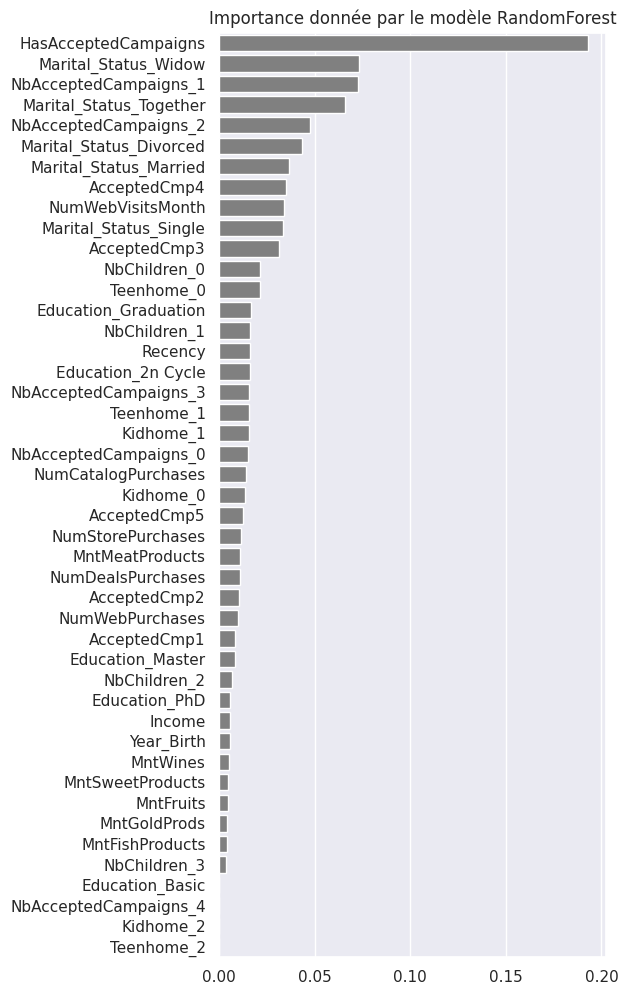

In [71]:
plt.figure(figsize=(5, 12))
plt.title("Importance donnée par le modèle RandomForest")
sns.barplot(fi, orient="h", color="gray")

## Permutation importance

In [72]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=SEED)

In [73]:
# sns.histplot(result.importances_std < 0.015)

In [74]:
pi_results = result.importances_mean

In [75]:
pi_results = pd.DataFrame(
    pi_results.reshape((1, len(pi_results))), columns=nom_colonnes
)
pi_results = pi_results.sort_values(by=0, axis=1, ascending=False)

<Axes: title={'center': 'Importance de Permutation du modèle RandomForest'}>

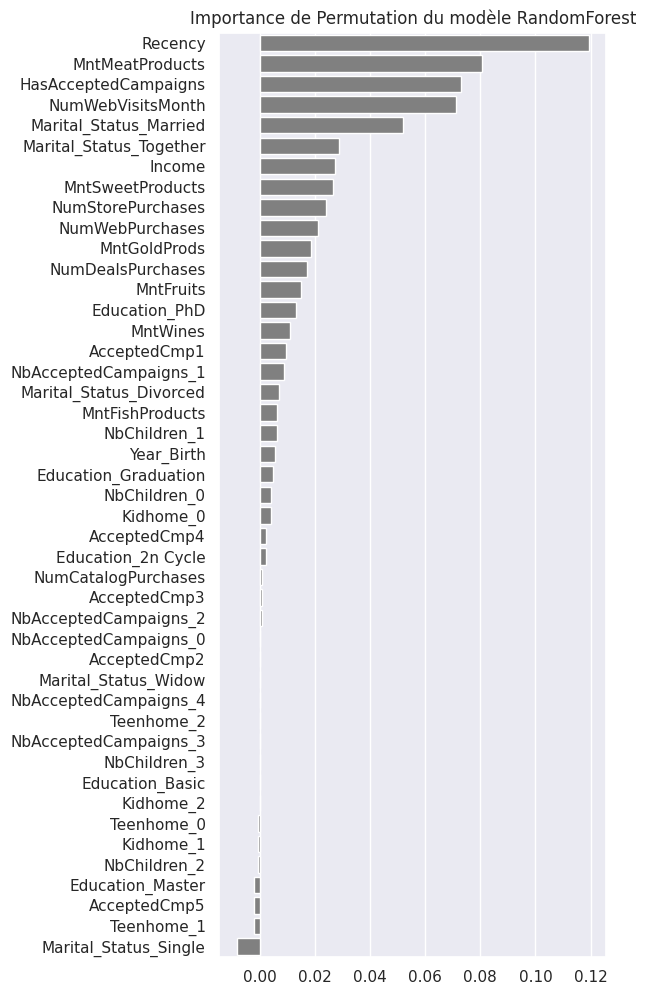

In [76]:
plt.figure(figsize=(5, 12))
plt.title("Importance de Permutation du modèle RandomForest")
sns.barplot(pi_results, orient="h", color="gray")

# Pour aller plus loin

- afficher les intervalles de confiance des scores de validation croisée
- optimiser les hyper-paramètres des modèles (avec une recherche en grille ou une recherche bayésienne)
- tester les modèles sur différents sous-ensembles de variables pour les comparer

# Sauvegarde des données

In [77]:
score_modeles_df = pd.DataFrame(
    score_modeles, columns=["Modèle", "Métrique", "Valeur", "Précision"]
)

In [78]:
score_modeles_df.to_csv("data/results/classifications.csv", index=False)